# Simple inversion
Here we will walkthrough a very simple gravity inversion using synthetic data. The goal of the inversion is to recover the geometry of a layer. In this case, the layer is simply the surface of the Earth, which is represented by the density contrast between air and rock.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

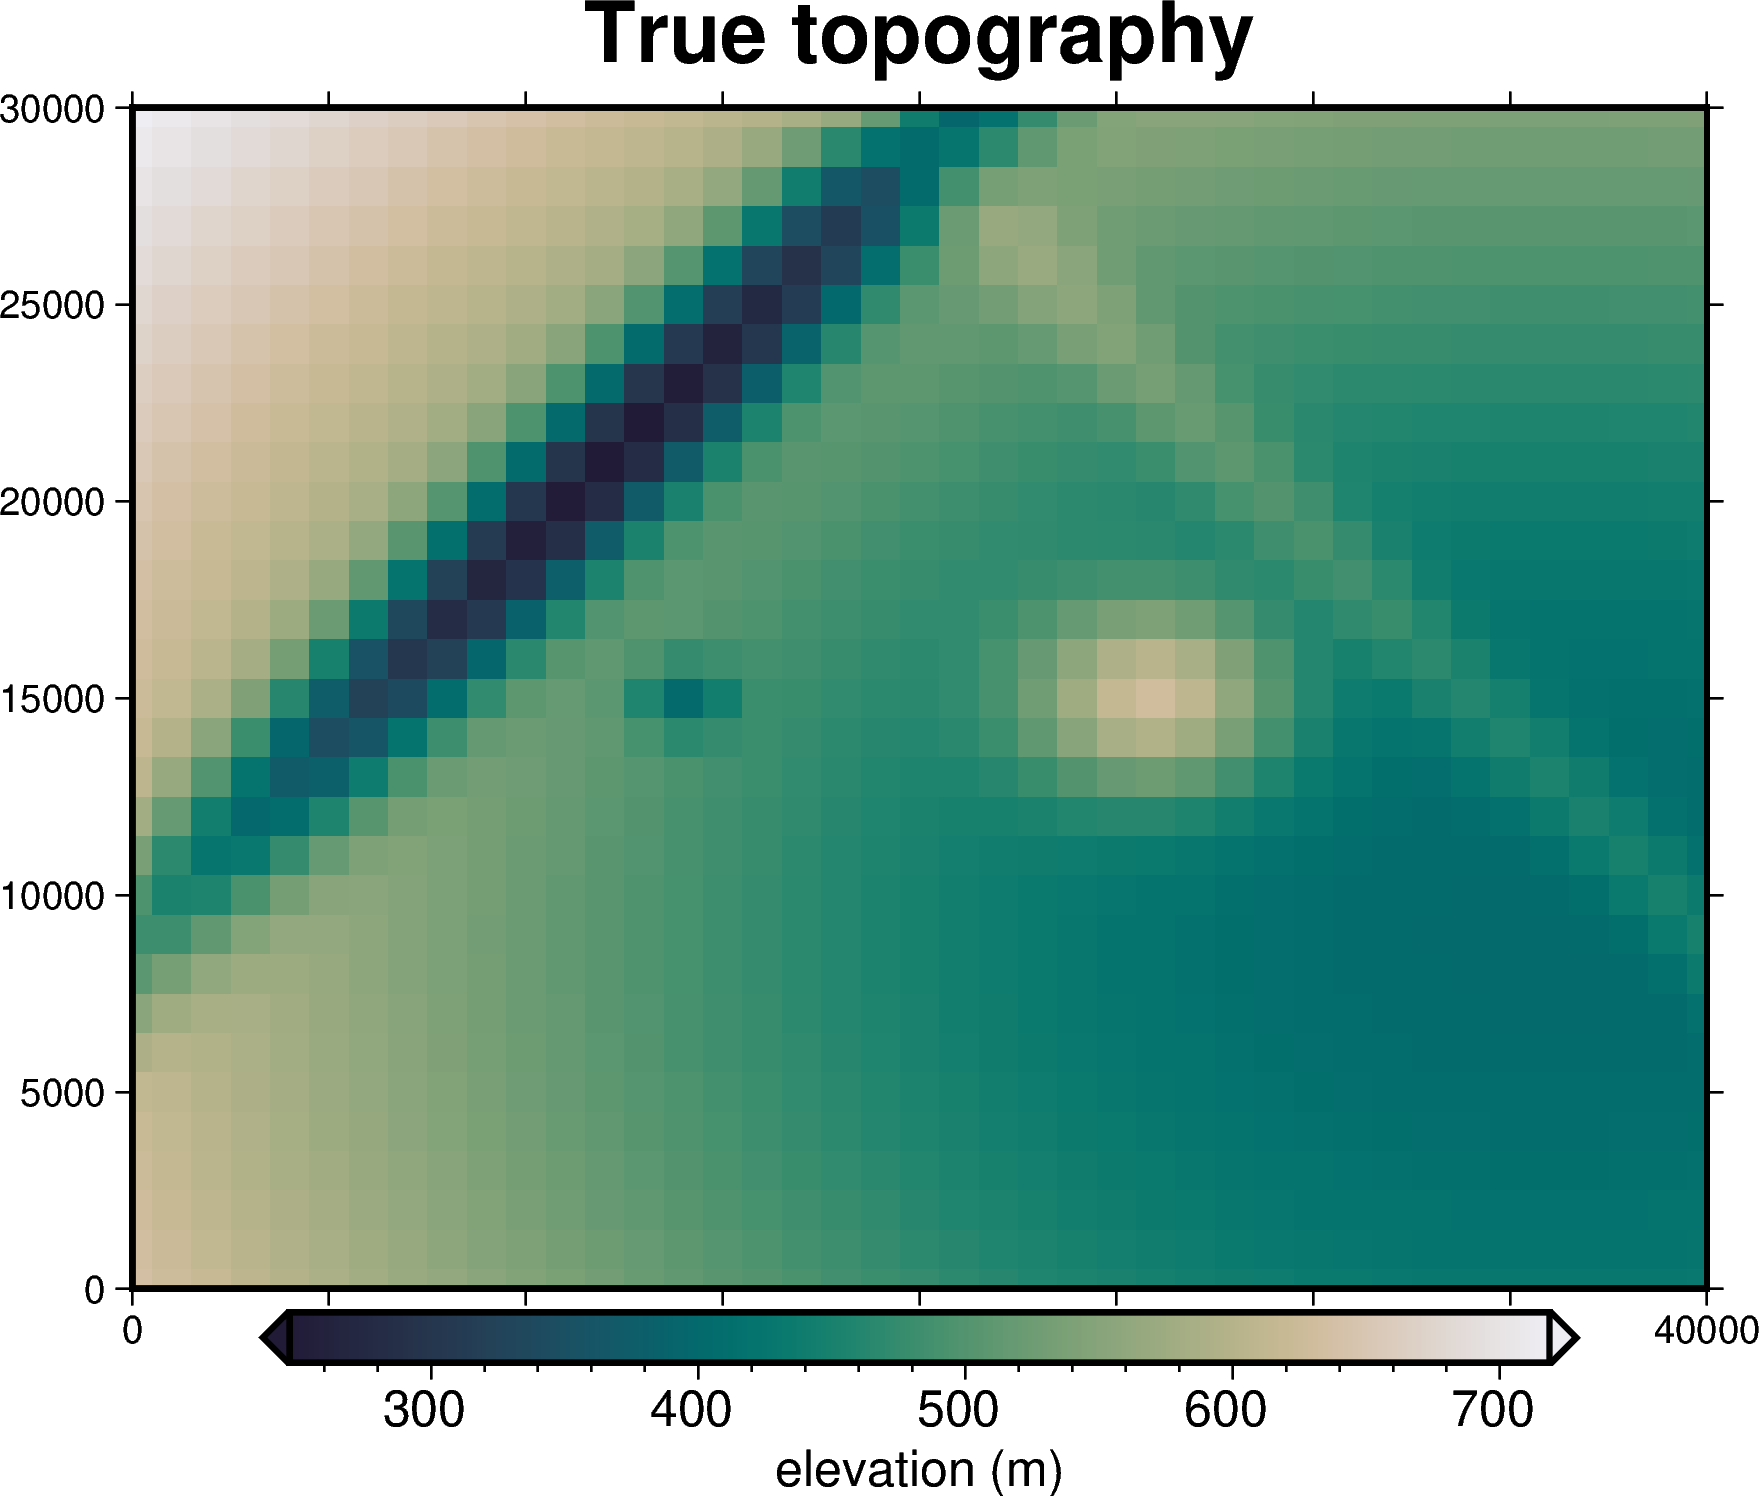

<xarray.DataArray 'upward' (northing: 31, easting: 41)> Size: 10kB
array([[637.12943453, 627.28784729, 617.55840384, ..., 428.39025144,
        429.33158321, 430.64751872],
       [632.95724141, 623.04617819, 613.24496334, ..., 422.67589466,
        423.6241977 , 424.94987872],
       [629.2139621 , 619.27333357, 609.41212904, ..., 417.59868139,
        418.55317844, 419.88752006],
       ...,
       [701.54094486, 692.82534357, 684.20926165, ..., 516.68829114,
        517.52190298, 518.68725132],
       [709.90739328, 701.33808009, 692.86661587, ..., 528.15742206,
        528.97704204, 530.12283044],
       [718.55151946, 710.13334959, 701.81130286, ..., 540.00720706,
        540.8123708 , 541.93795008]])
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

true_topography

### Prism layer

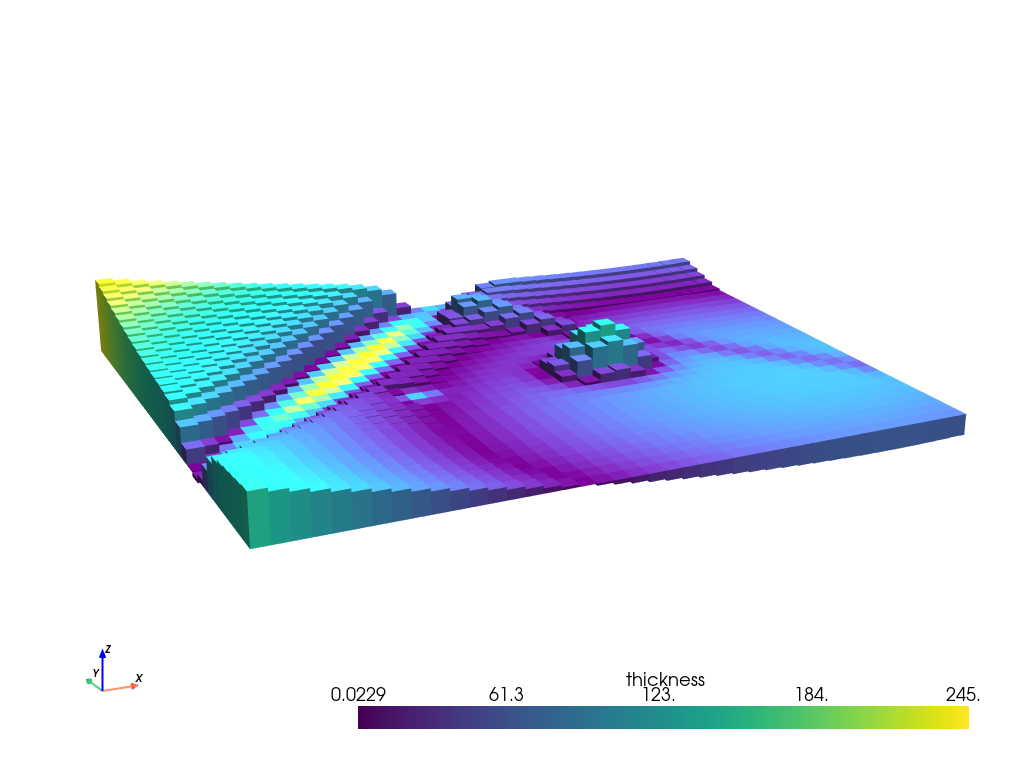

mean topography is 492.2704164812973 m


In [3]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {zref} m")

### Forward gravity of prism layer

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


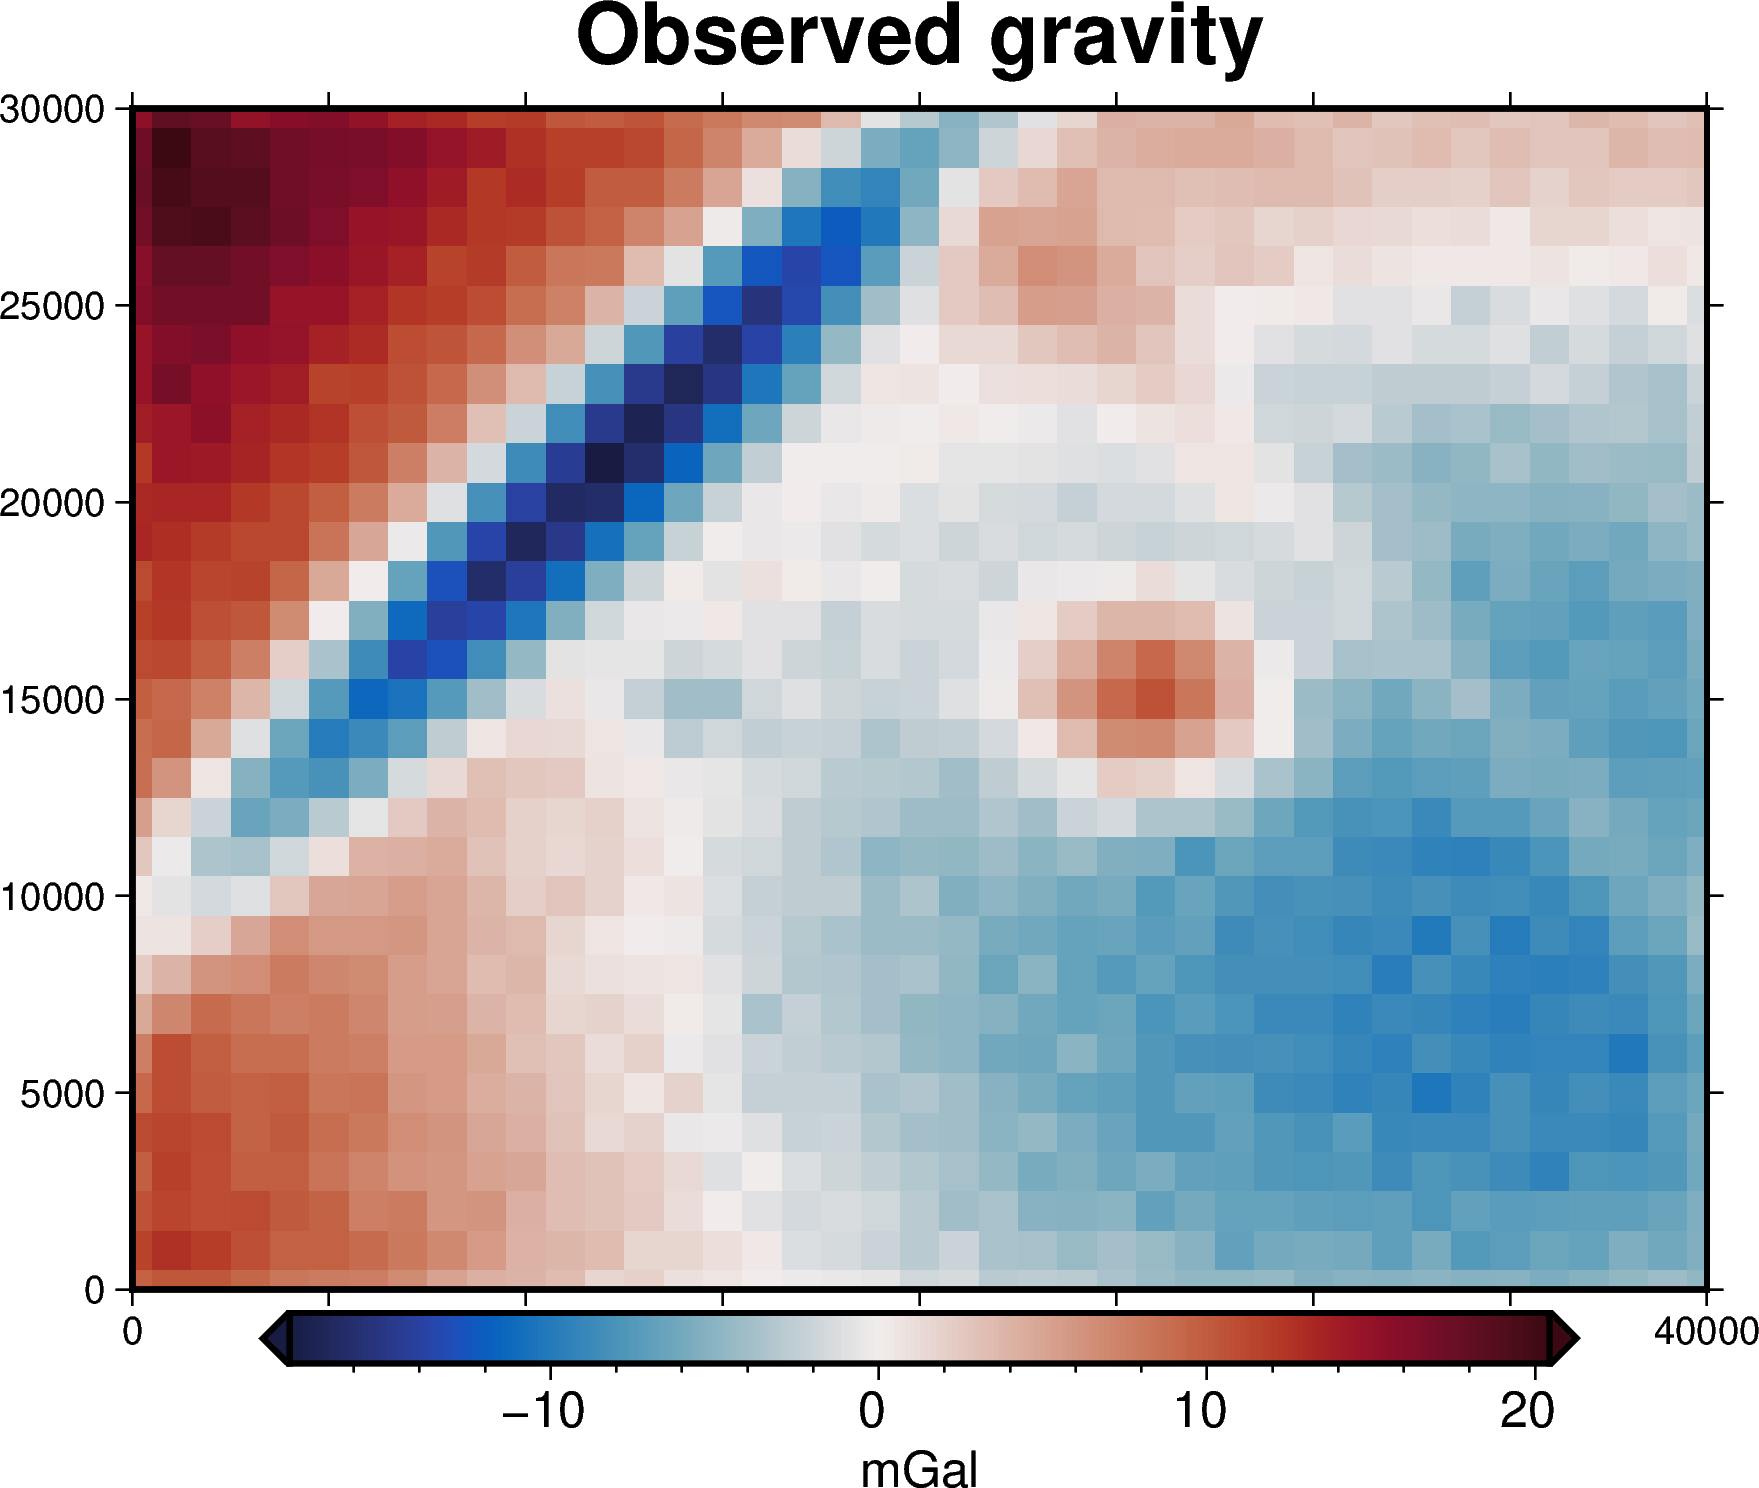

In [7]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    grd2_cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model of the topography to start the inversion with. Since here we have no knowledge of either the topography or the appropriate reference level (`zref`), the starting model is flat, and therefore it's forward gravity is 0. If you had a non-flat starting model, you would need to calculate it's forward gravity effect, and subtract it from our observed gravity to get a starting gravity misfit. 

In this simple case, we assume that we know the true density contrast and appropriate reference value for the topography (`zref`), and use these values to create our flat starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

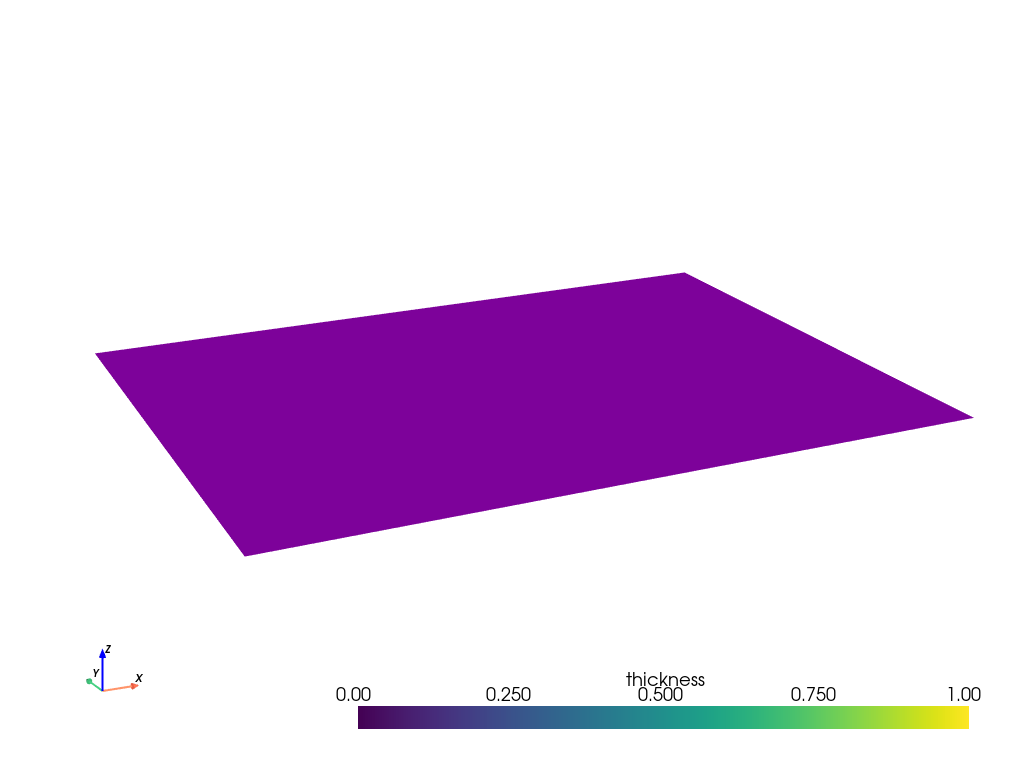

In [8]:
# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms are created between zref and the height of the topography, which for this
# starting model is flat.
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [9]:
# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

,northing,easting,upward,grav,observed_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,9.617711,9.617711,0,9.617711
1,0.0,1000.0,1000.0,10.422834,10.376985,10.376985,0,10.376985
2,0.0,2000.0,1000.0,9.949973,10.290387,10.290387,0,10.290387
3,0.0,3000.0,1000.0,9.269279,9.341932,9.341932,0,9.341932
4,0.0,4000.0,1000.0,8.532160,8.284528,8.284528,0,8.284528
...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,2.794223,2.794223,0,2.794223
1267,30000.0,37000.0,1000.0,3.330307,3.683446,3.683446,0,3.683446
1268,30000.0,38000.0,1000.0,3.335438,3.501867,3.501867,0,3.501867
1269,30000.0,39000.0,1000.0,3.300721,2.848068,2.848068,0,2.848068


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0


Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -5.8688 m, RMSE:33.4447 m
INFO:root:updated misfit RMSE: 4.0977
INFO:root:updated L2-norm: 2.0243, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3213, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 12.4689 m, RMSE:18.6922 m
INFO:root:updated misfit RMSE: 2.4491
INFO:root:updated L2-norm: 1.565, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2935, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 6.9708 m, RMSE:10.7744 m
INFO:root:updated misfit RMSE: 1.5522
INFO:root:updated L2-norm: 1.2459, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2561, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 4.0446 m, RMSE:6.4739 m
INFO:root:updated misfit RMSE: 1.0568
INFO:root:updated L2-norm: 1.

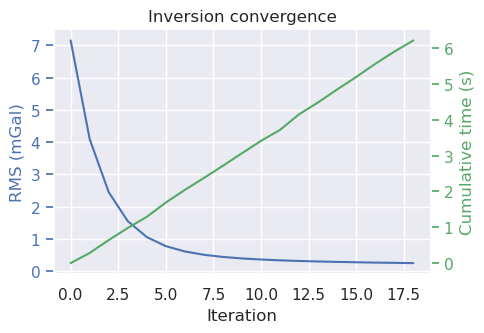

In [11]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

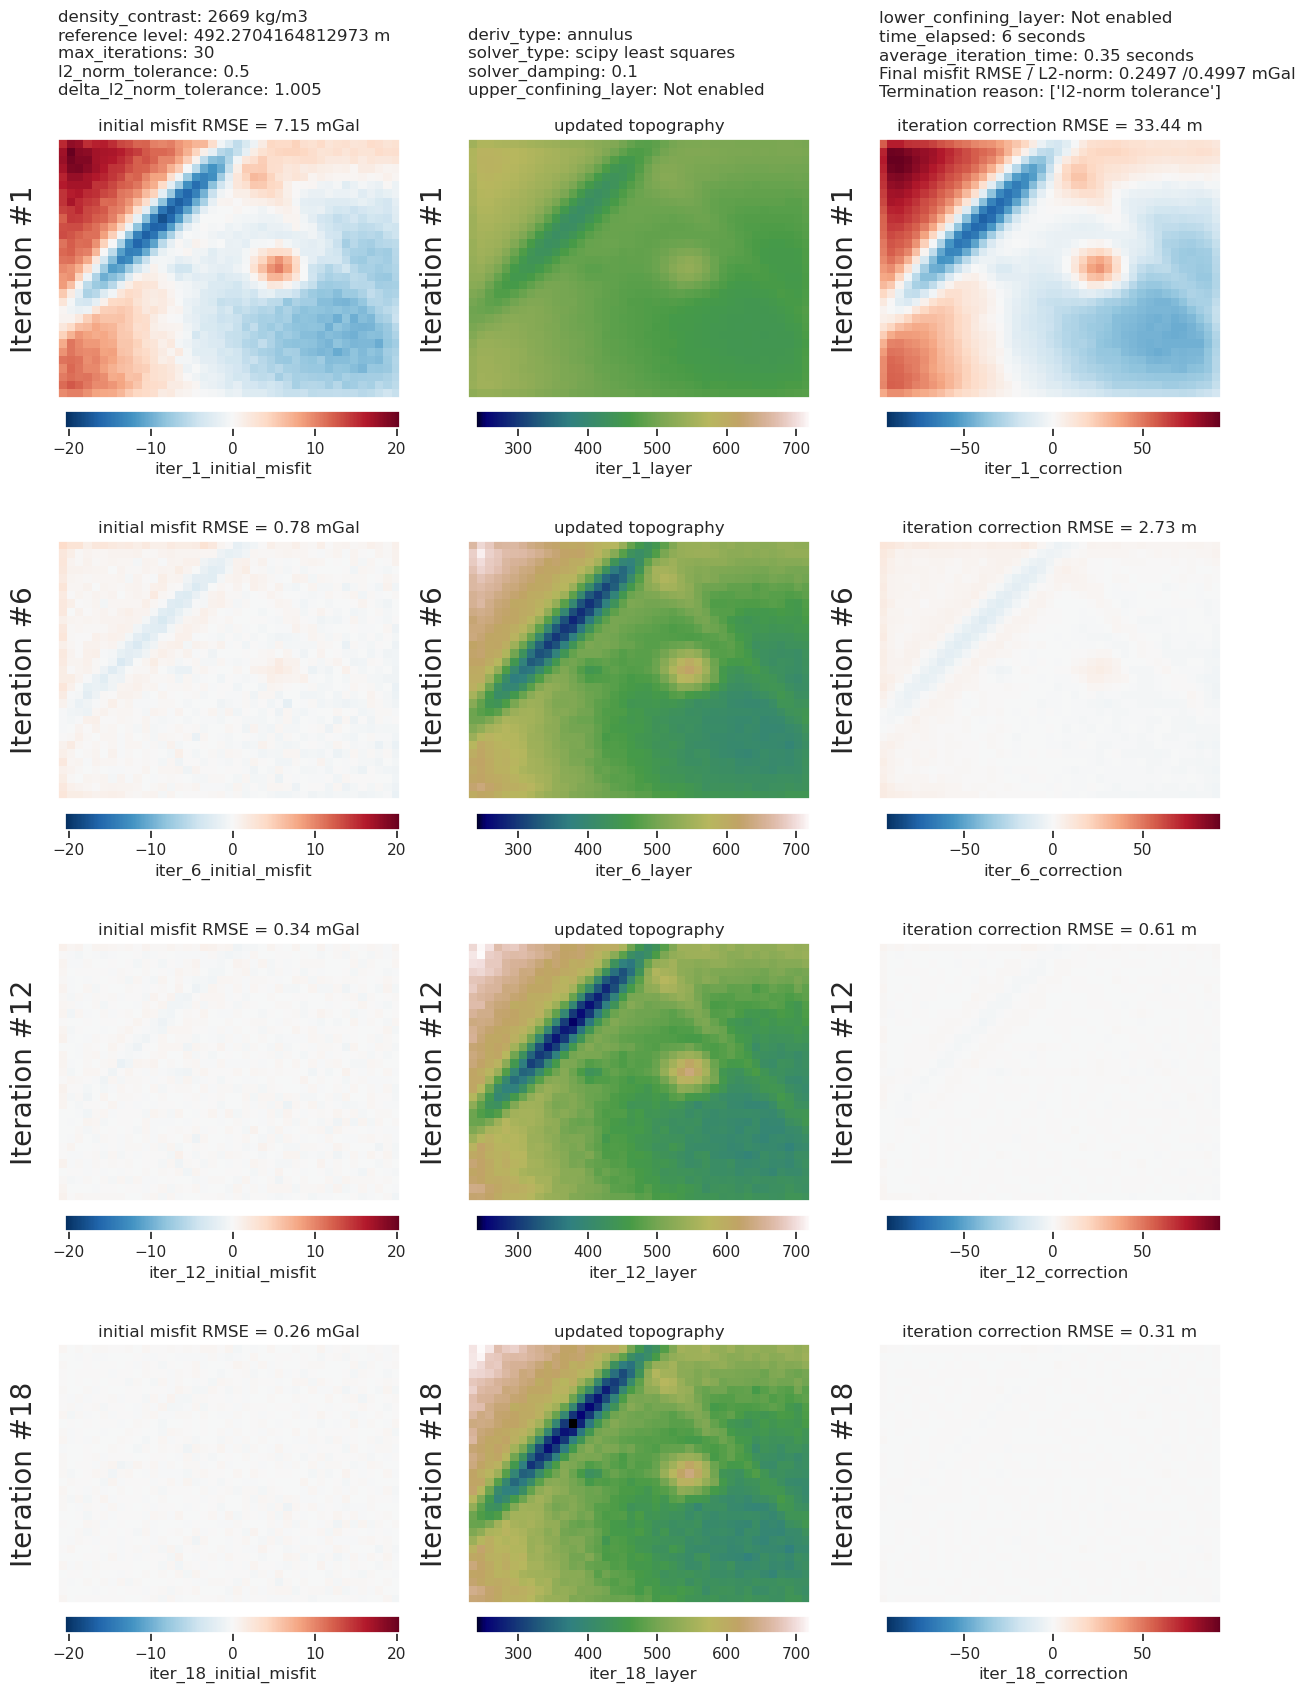

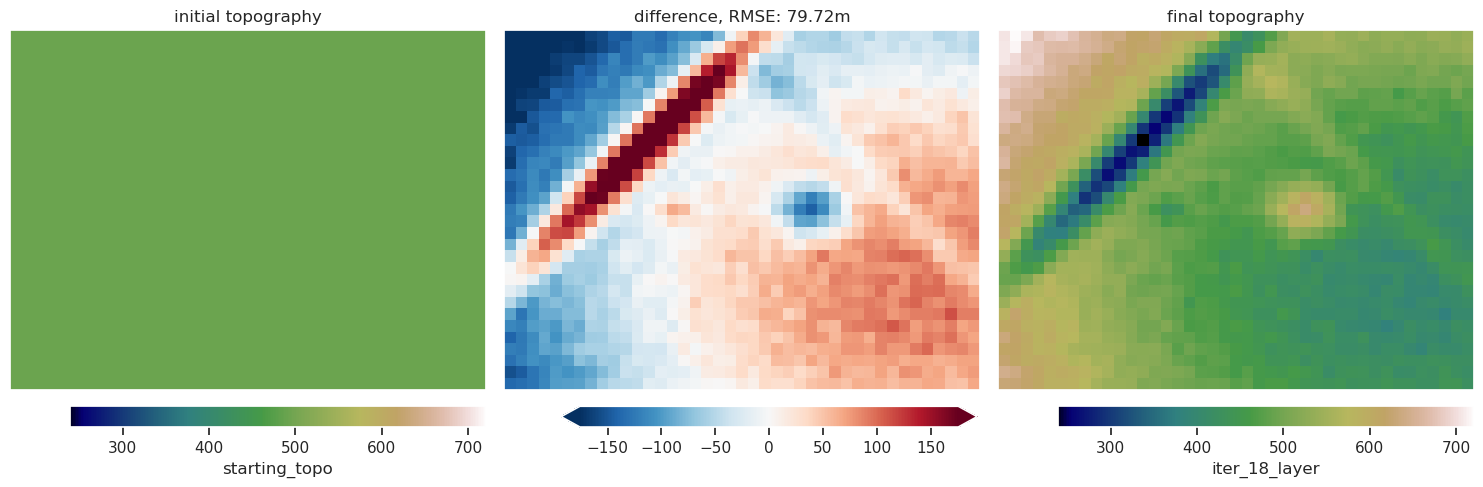

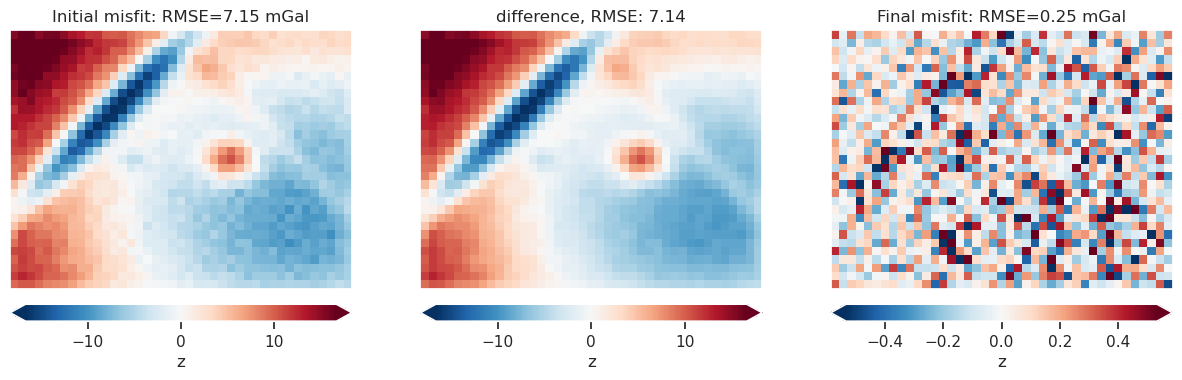

In [12]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

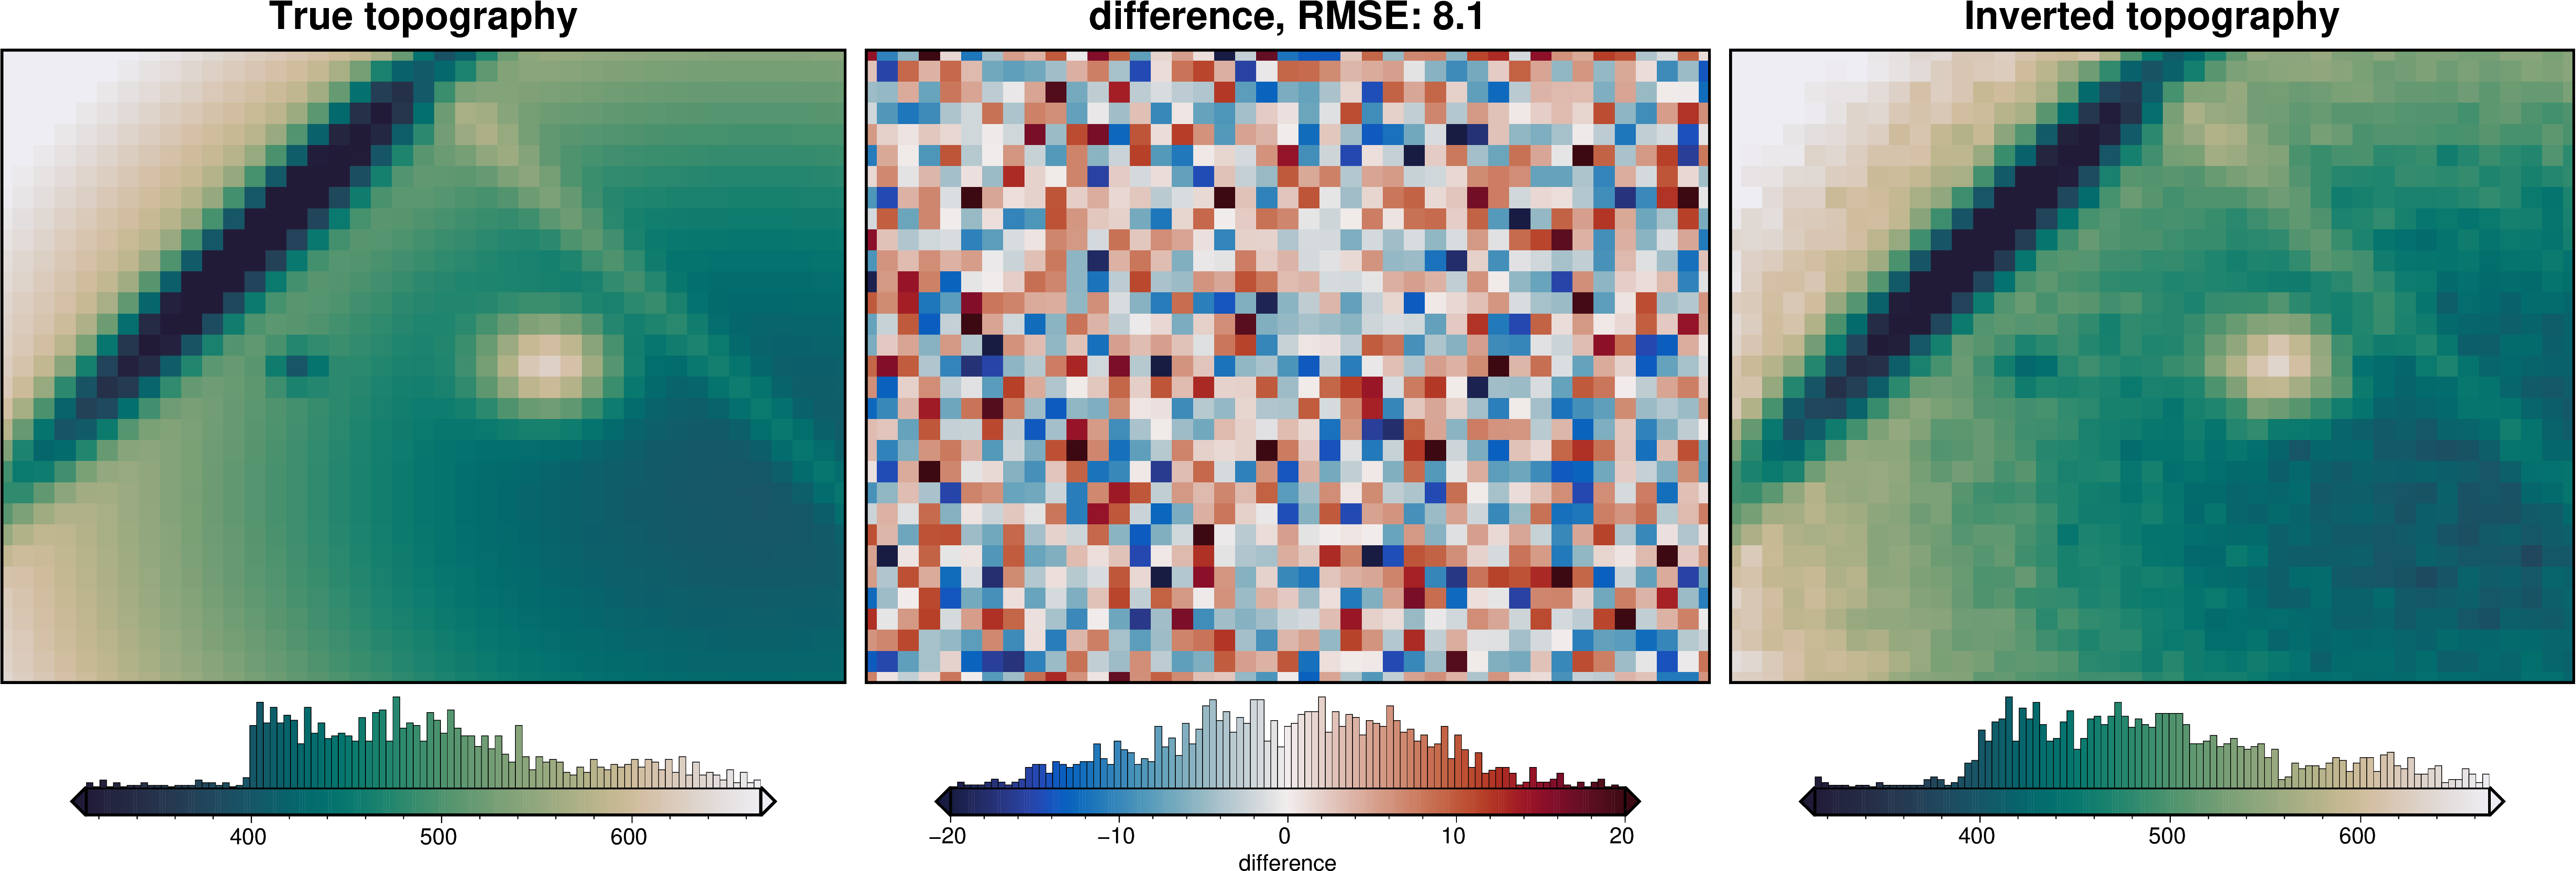

In [14]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too suprising since we gave the inversion the true density contrast and appropriate zref value.

See `reference_level_cross_validation.ipynb` and `density_cross_validation.ipynb` for examples of how to best choose those values in scenarios where you don't know them.

The next notebook, `damping_cross_validation.ipynb` will explain how to use cross validation to choose the optimal damping parameter value. Here, we simply chose an arbitrary value which appeared to work well. With real data with noise, this choice of the damping parameter becomes very important. 